In [1]:
# GraphQL
from pyammanalysis import run_query
from gql import gql, Client
from gql.transport.aiohttp import AIOHTTPTransport

# I/O
from pprint import pprint
import json
import os
import glob

# statistical analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import MaxNLocator
from pyammanalysis import pwlf_helper

import datetime as dt
import math

In [2]:
uniswap_v3_subgraph_url = "https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v3"
refetch = True
data_folder = "data"
pool_day_data_folder = os.path.join(data_folder, "pool", "day")

# TODO: whitelist by address, not symbols
whitelisted_symbols = ["BUSD", "USDC", "USDT", "DAI", "WETH", "WBNB", "WBTC"]

In [3]:
TEN_LARGEST_TVL_POOLS_QUERY = """
{
    pools(first: 10, orderBy: totalValueLockedUSD, orderDirection: desc) {
        id
    } 
}
"""
if refetch:
    largest_tvl_pool_ids = run_query(uniswap_v3_subgraph_url, TEN_LARGEST_TVL_POOLS_QUERY)
    largest_tvl_pool_addrs = list(map(lambda x: x["id"], largest_tvl_pool_ids["data"]["pools"]))
    print(largest_tvl_pool_addrs)

['0xa850478adaace4c08fc61de44d8cf3b64f359bec', '0x5777d92f208679db4b9778590fa3cab3ac9e2168', '0x6c6bc977e13df9b0de53b251522280bb72383700', '0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8', '0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640', '0xc63b0708e2f7e69cb8a1df0e1389a98c35a76d52', '0x3416cf6c708da44db2624d63ea0aaef7113527c6', '0xcbcdf9626bc03e24f779434178a73a0b4bad62ed', '0x8ee3cc8e29e72e03c4ab430d7b7e08549f0c71cc', '0x4e68ccd3e89f51c3074ca5072bbac773960dfa36']


In [4]:
GET_POOL_BY_ID_QUERY = gql(
    """
    query getPoolById($pool_addr: ID!) {
        pool(id: $pool_addr) {
            tick
            token0 {
                symbol
                id
                decimals
            }
            token1 {
                symbol
                id
                decimals
            }
            feeTier
            sqrtPrice
            liquidity
        }
    }
    """
)

In [5]:
async def fetch_pools_metadata(addresses: list, verbose: bool=False):
    result = {"topPoolDatas": []}

    transport = AIOHTTPTransport(url=uniswap_v3_subgraph_url)

    async with Client(
        transport=transport,
        fetch_schema_from_transport=True,
    ) as session:
        for id in addresses:
            params = {"pool_addr": id}
            temp = await session.execute(GET_POOL_BY_ID_QUERY, variable_values=params)
            result["topPoolDatas"].append(temp["pool"])

    if verbose:
        pprint(result)

    if not os.path.exists(data_folder):
        os.makedirs(data_folder)

    with open(f"{data_folder}/topPoolDatas.json", "w") as f:
        json.dump(result, f, indent=4)

In [6]:
if refetch:
    await fetch_pools_metadata(largest_tvl_pool_addrs)

In [7]:
def format_pool_name(symbol0: str, symbol1: str, fee_tier: int) -> str:
    return f"{symbol0}_{symbol1}_{fee_tier}"

In [8]:
with open(f"{data_folder}/topPoolDatas.json", "r") as f:
    top_pool_datas = json.load(f)

# TODO: better token symbol mapping
token_symbols = dict()

# replace nested dict with token addr
for pool_dict in top_pool_datas["topPoolDatas"]:
    for token in ["token0", "token1"]:
        token_symbols[pool_dict[token]["id"]] = pool_dict[token]["symbol"]
        pool_dict[token] = pool_dict[token]["id"]

top_pools_df = pd.DataFrame.from_dict(top_pool_datas["topPoolDatas"]).astype({
    "token0": str,
    "token1": str,
    "feeTier": int
})

# add addr and name
top_pools_df["pool_addr"] = largest_tvl_pool_addrs
top_pools_df["name"] = top_pools_df.apply(lambda x: format_pool_name(token_symbols[x["token0"]], token_symbols[x["token1"]], x["feeTier"]), axis=1)

# drop unused cols
top_pools_df.drop(columns=["tick", "sqrtPrice", "liquidity"], inplace=True)

# drop pools without whitelisted symbols
has_whitelisted_symbols = top_pools_df["name"].str.contains("|".join(whitelisted_symbols))
top_pools_df = top_pools_df[has_whitelisted_symbols]

top_pools_df.head()

,token0,token1,feeTier,pool_addr,name
1,0x6b175474e89094c44da98b954eedeac495271d0f,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,100,0x5777d92f208679db4b9778590fa3cab3ac9e2168,DAI_USDC_100
2,0x6b175474e89094c44da98b954eedeac495271d0f,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,500,0x6c6bc977e13df9b0de53b251522280bb72383700,DAI_USDC_500
3,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,3000,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,USDC_WETH_3000
4,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,500,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,USDC_WETH_500
5,0x853d955acef822db058eb8505911ed77f175b99e,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,500,0xc63b0708e2f7e69cb8a1df0e1389a98c35a76d52,FRAX_USDC_500


In [9]:
top_pools_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9 entries, 1 to 9
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   token0     9 non-null      object
 1   token1     9 non-null      object
 2   feeTier    9 non-null      int32 
 3   pool_addr  9 non-null      object
 4   name       9 non-null      object
dtypes: int32(1), object(4)
memory usage: 396.0+ bytes


### Replicating the Info Page
We perform the following two queries over 1000 days (at most):
1. TVL
2. 24H Volume

In [10]:
POOL_CHART = gql(
    """
    query poolDayDatas($startTime: Int!, $skip: Int!, $address: String!) {
        poolDayDatas(
            first: 1000
            skip: $skip
            where: { pool: $address, date_gt: $startTime }
            orderBy: date
            orderDirection: asc
            subgraphError: allow
        ) {
            date
            volumeUSD
            tvlUSD
            feesUSD
        }
    }
    """
)

In [11]:
fetch_pool_error = []

# ref: https://github.com/Uniswap/v3-info/blob/770a05dc1a191cf229432ebc43c1f2ceb3666e3b/src/data/pools/chartData.ts#L14
async def fetch_pool_chart_data(address: str, symbol0: str, symbol1: str, fee_tier: int, verbose: bool=False):
    START_TIMESTAMP = 1619170975 # GMT: Friday, April 23, 2021 9:42:55 AM
    # END_TIMESTAMP = int(time.time()) # current timestamp

    error = False
    skip = 0
    all_found = False
    result = {"poolDayDatas": []}

    transport = AIOHTTPTransport(url=uniswap_v3_subgraph_url)

    async with Client(
        transport=transport,
        fetch_schema_from_transport=True,
    ) as session:
        params = {
            "address": address,
            "startTime": START_TIMESTAMP,
            "skip": skip
        }
        try:
            while not all_found:
                temp = await session.execute(POOL_CHART, variable_values=params)
                skip += 1000
                if len(temp["poolDayDatas"]) < 1000 or error:
                    all_found = True
                if temp:
                    result["poolDayDatas"] = result["poolDayDatas"] + temp["poolDayDatas"] # concat the lists
        except Exception as e:
            print(e)
            error = True
            fetch_pool_error.append(address)

    if not error:
        if verbose:
            pprint(result)

        if not os.path.exists(pool_day_data_folder):
            os.makedirs(pool_day_data_folder)

        with open(f"{pool_day_data_folder}/{format_pool_name(symbol0, symbol1, fee_tier)}.json", "w") as f:
            json.dump(result, f, indent=4)

In [12]:
if refetch:
    # remove existing content in the out folder
    for f in glob.glob(pool_day_data_folder + "/*"):
        os.remove(f)

    # fetch pool data for each pool
    for i, row in top_pools_df.iterrows():
        await fetch_pool_chart_data(row["pool_addr"], token_symbols[row["token0"]], token_symbols[row["token1"]], row["feeTier"])
    print(fetch_pool_error)


['0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640']


In [13]:
# reads pool day datas from json
df = pd.DataFrame(columns=["date"])
pool_names = []

for f in os.listdir(pool_day_data_folder):
    fullname = os.fsdecode(f)

    # not a rigorous check
    with open(os.path.join(pool_day_data_folder, fullname), "r") as file:
        pool_day_datas = json.load(file)

    # parse dict as df
    temp = pd.DataFrame.from_dict(pool_day_datas["poolDayDatas"]).astype({
        "volumeUSD": np.float64,
        "tvlUSD": np.float64
    })

    # Note: there is no need to analyze fees separately,
    # as it is a fixed proportion of the pool's trade volume
    temp.drop(columns=["feesUSD"], inplace=True)

    # prefix columns (except "date") with pool name
    cols = temp.columns[~temp.columns.isin(["date"])]
    pool_name = fullname.split(os.sep)[-1].split(".")[0]
    pool_names.append(pool_name)
    temp.rename(columns = dict(zip(cols, pool_name + "_" + cols)), inplace=True)

    # outer join: union of items on "date"
    df = pd.merge(df, temp, how="outer", on=["date"])

# sort by "date"
df.sort_values(by="date", inplace=True)
df.reset_index(drop="index", inplace=True)

df.head()

,date,DAI_USDC_100_volumeUSD,DAI_USDC_100_tvlUSD,DAI_USDC_500_volumeUSD,DAI_USDC_500_tvlUSD,FRAX_USDC_500_volumeUSD,FRAX_USDC_500_tvlUSD,USDC_USDM_500_volumeUSD,USDC_USDM_500_tvlUSD,USDC_USDT_100_volumeUSD,USDC_USDT_100_tvlUSD,USDC_WETH_3000_volumeUSD,USDC_WETH_3000_tvlUSD,WBTC_WETH_3000_volumeUSD,WBTC_WETH_3000_tvlUSD,WETH_USDT_3000_volumeUSD,WETH_USDT_3000_tvlUSD
0,1620086400,NaN,NaN,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN
1,1620172800,NaN,NaN,1.455737e+06,8.034837e+06,NaN,NaN,NaN,NaN,NaN,NaN,2.285047e+06,1.620270e+07,4.925324e+05,8.760155e+06,9.761890e+05,2.609716e+06
2,1620259200,NaN,NaN,1.519308e+07,1.732428e+07,0.000000,162.304730,NaN,NaN,NaN,NaN,4.424415e+07,5.529764e+07,7.507954e+06,3.459820e+07,2.672544e+07,2.649779e+07
3,1620345600,NaN,NaN,1.123453e+07,2.094898e+07,500.000000,1323.207605,NaN,NaN,NaN,NaN,4.676004e+07,6.546200e+07,1.097052e+07,4.508025e+07,5.404438e+07,5.371375e+07
4,1620432000,NaN,NaN,1.691480e+07,2.929597e+07,26075.186321,21328.433014,NaN,NaN,NaN,NaN,5.514085e+07,6.519641e+07,2.327335e+07,5.307294e+07,9.324547e+07,5.172409e+07


In [14]:
# ["date"]: int -> date (in "YYYY-MM-DD")
df["timestamp"] = df["date"] # keep timestamp in a new col
df["date"] = df["date"].map(dt.date.fromtimestamp)

df.head()

,date,DAI_USDC_100_volumeUSD,DAI_USDC_100_tvlUSD,DAI_USDC_500_volumeUSD,DAI_USDC_500_tvlUSD,FRAX_USDC_500_volumeUSD,FRAX_USDC_500_tvlUSD,USDC_USDM_500_volumeUSD,USDC_USDM_500_tvlUSD,USDC_USDT_100_volumeUSD,USDC_USDT_100_tvlUSD,USDC_WETH_3000_volumeUSD,USDC_WETH_3000_tvlUSD,WBTC_WETH_3000_volumeUSD,WBTC_WETH_3000_tvlUSD,WETH_USDT_3000_volumeUSD,WETH_USDT_3000_tvlUSD,timestamp
0,2021-05-04,NaN,NaN,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,1620086400
1,2021-05-05,NaN,NaN,1.455737e+06,8.034837e+06,NaN,NaN,NaN,NaN,NaN,NaN,2.285047e+06,1.620270e+07,4.925324e+05,8.760155e+06,9.761890e+05,2.609716e+06,1620172800
2,2021-05-06,NaN,NaN,1.519308e+07,1.732428e+07,0.000000,162.304730,NaN,NaN,NaN,NaN,4.424415e+07,5.529764e+07,7.507954e+06,3.459820e+07,2.672544e+07,2.649779e+07,1620259200
3,2021-05-07,NaN,NaN,1.123453e+07,2.094898e+07,500.000000,1323.207605,NaN,NaN,NaN,NaN,4.676004e+07,6.546200e+07,1.097052e+07,4.508025e+07,5.404438e+07,5.371375e+07,1620345600
4,2021-05-08,NaN,NaN,1.691480e+07,2.929597e+07,26075.186321,21328.433014,NaN,NaN,NaN,NaN,5.514085e+07,6.519641e+07,2.327335e+07,5.307294e+07,9.324547e+07,5.172409e+07,1620432000


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408 entries, 0 to 407
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   date                      408 non-null    object 
 1   DAI_USDC_100_volumeUSD    215 non-null    float64
 2   DAI_USDC_100_tvlUSD       215 non-null    float64
 3   DAI_USDC_500_volumeUSD    408 non-null    float64
 4   DAI_USDC_500_tvlUSD       408 non-null    float64
 5   FRAX_USDC_500_volumeUSD   386 non-null    float64
 6   FRAX_USDC_500_tvlUSD      386 non-null    float64
 7   USDC_USDM_500_volumeUSD   12 non-null     float64
 8   USDC_USDM_500_tvlUSD      12 non-null     float64
 9   USDC_USDT_100_volumeUSD   215 non-null    float64
 10  USDC_USDT_100_tvlUSD      215 non-null    float64
 11  USDC_WETH_3000_volumeUSD  408 non-null    float64
 12  USDC_WETH_3000_tvlUSD     408 non-null    float64
 13  WBTC_WETH_3000_volumeUSD  408 non-null    float64
 14  WBTC_WETH_

In [16]:
# sanity check for number of days elapsed
print(df["date"][0], "to", dt.date.today(), "has", (dt.date.today() - df["date"][0]))

2021-05-04 to 2022-06-15 has 407 days, 0:00:00


## 24H Volume Analysis

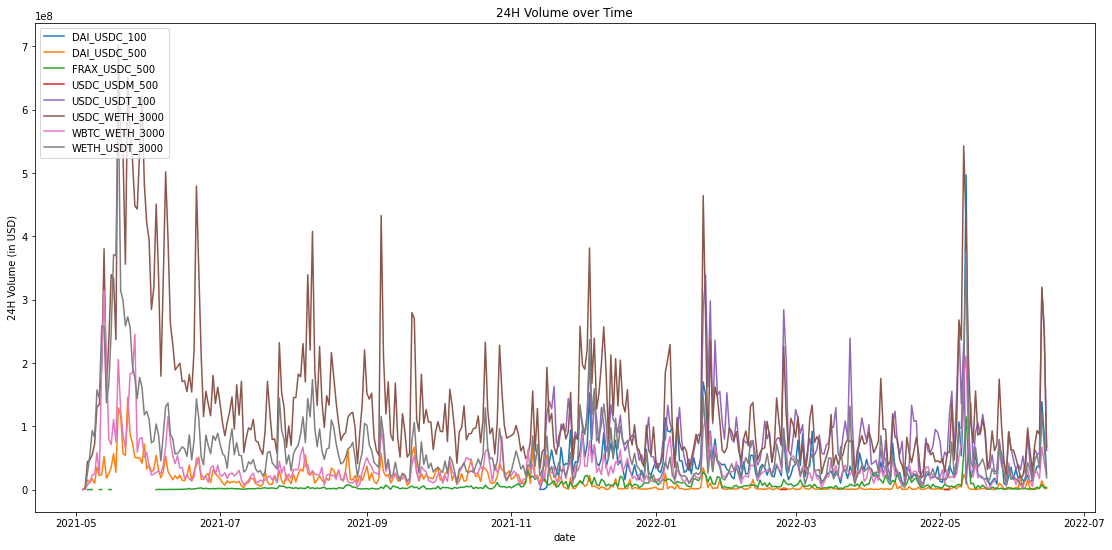

In [17]:
plt.figure(figsize=(19, 9))
for pool_name in pool_names:
    plt.plot(df["date"], df[pool_name + "_volumeUSD"])
plt.title("24H Volume over Time")
plt.xlabel("date")
plt.ylabel("24H Volume (in USD)")
plt.legend(pool_names, loc='upper left')
plt.show()

In [18]:
# find the days with the greatest 24H volumes
# df.sort_values(by="volumeUSD", ascending=False)[:10]

In [19]:
# # for reference only, no use now
# fig, ax = plt.subplots(figsize=(15, 1))
# sns.boxplot(data=df, x="volumeUSD")
# plt.xlim(0, 2e8)
# plt.show()

### Histogram
Observe the distribution of the prices.

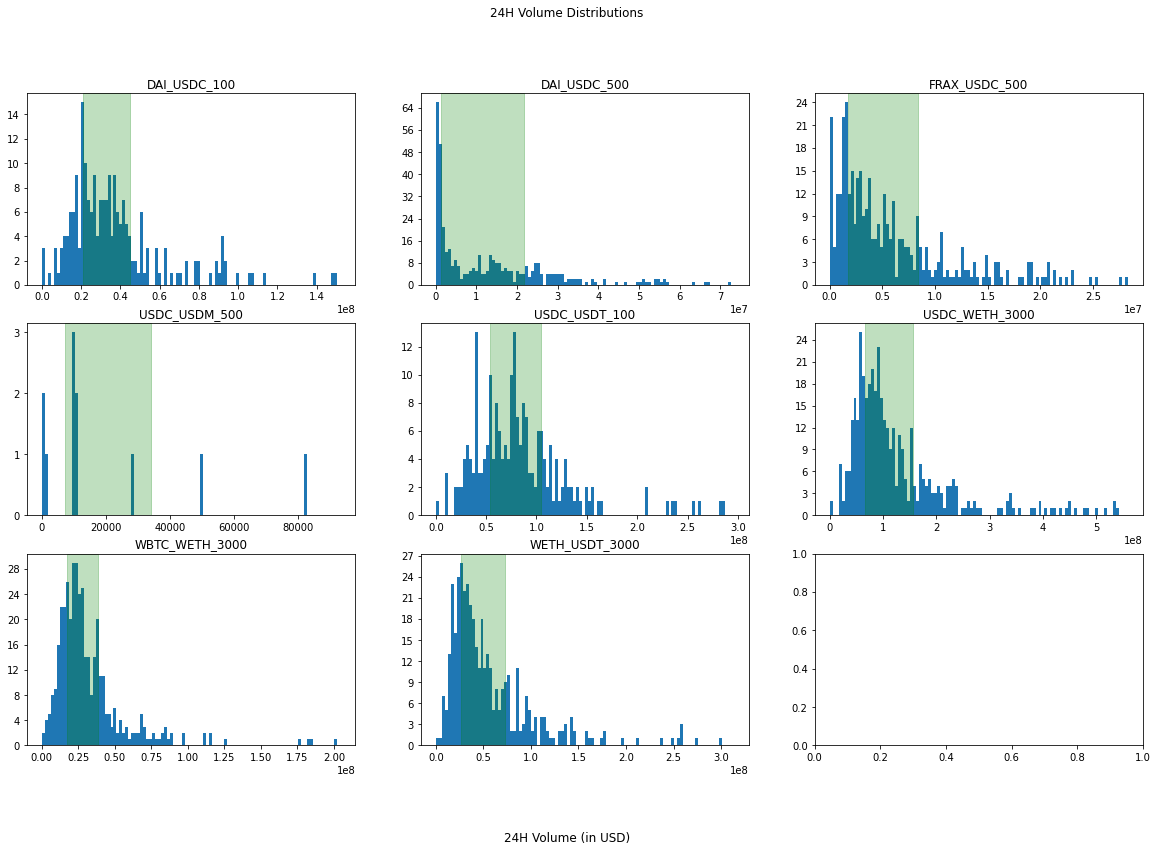

In [20]:
fig = plt.figure(figsize=(20, 12))
axes = fig.subplots(3, 3)
for i, pool_name in enumerate(pool_names):
    volumeUSD_series = df[pool_name + "_volumeUSD"]
    ax = axes[math.floor(i/3), i%3]
    ax.title.set_text(pool_name)
    ax.hist(volumeUSD_series, bins=100, range=(0, volumeUSD_series.quantile(0.99)))

    # force y-axis ticks to use integers
    ax.get_yaxis().set_major_locator(MaxNLocator(integer=True))

    # highlight 25%-75% percentile
    lq = volumeUSD_series.quantile(0.25)
    uq = volumeUSD_series.quantile(0.75)
    ax.axvspan(lq, uq, color="green", alpha=0.25)

fig.suptitle("24H Volume Distributions")
fig.supxlabel("24H Volume (in USD)")
plt.show()

In [21]:
pool_df = df.drop(columns="timestamp")
# note: df.std() is normalized by N-1
pool_metrics_df = pd.DataFrame(data=[pool_df.mean(), pool_df.std()], index=["mean", "stdev"])
pool_metrics_df

C:\Users\user\AppData\Local\Temp\ipykernel_12920\2952147379.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pool_metrics_df = pd.DataFrame(data=[pool_df.mean(), pool_df.std()], index=["mean", "stdev"])


,DAI_USDC_100_volumeUSD,DAI_USDC_100_tvlUSD,DAI_USDC_500_volumeUSD,DAI_USDC_500_tvlUSD,FRAX_USDC_500_volumeUSD,FRAX_USDC_500_tvlUSD,USDC_USDM_500_volumeUSD,USDC_USDM_500_tvlUSD,USDC_USDT_100_volumeUSD,USDC_USDT_100_tvlUSD,USDC_WETH_3000_volumeUSD,USDC_WETH_3000_tvlUSD,WBTC_WETH_3000_volumeUSD,WBTC_WETH_3000_tvlUSD,WETH_USDT_3000_volumeUSD,WETH_USDT_3000_tvlUSD
mean,4.074876e+07,2.558340e+08,1.420461e+07,1.068446e+08,6.493033e+06,1.498147e+08,25665.466982,9.583349e+07,8.686264e+07,1.788306e+08,1.332747e+08,3.370996e+08,3.443477e+07,2.607708e+08,6.040662e+07,1.531050e+08
stdev,4.214856e+07,1.898339e+08,1.816484e+07,5.660051e+07,8.696344e+06,9.686368e+07,32490.327511,1.443377e+07,5.517577e+07,4.959278e+07,1.121875e+08,7.542624e+07,3.417051e+07,7.619340e+07,6.170916e+07,3.398906e+07


In [22]:
# # for reference only, no use now
# df["volumeUSD"].plot.kde()
# plt.title(pool_name + " 24H Volume KDE")
# plt.xlim(0, 2e8)
# plt.show()

In [23]:
# TODO: time series / autocorelation
# TODO: aggregate weekly and daily patterns and look for anomalies (e.g. Friday)
# TODO: ask for calculation of Greeks (Detla, Vega...)

### Fast Fourier Transform (FFT)
FFT computes the frequency content of the prices as signals.

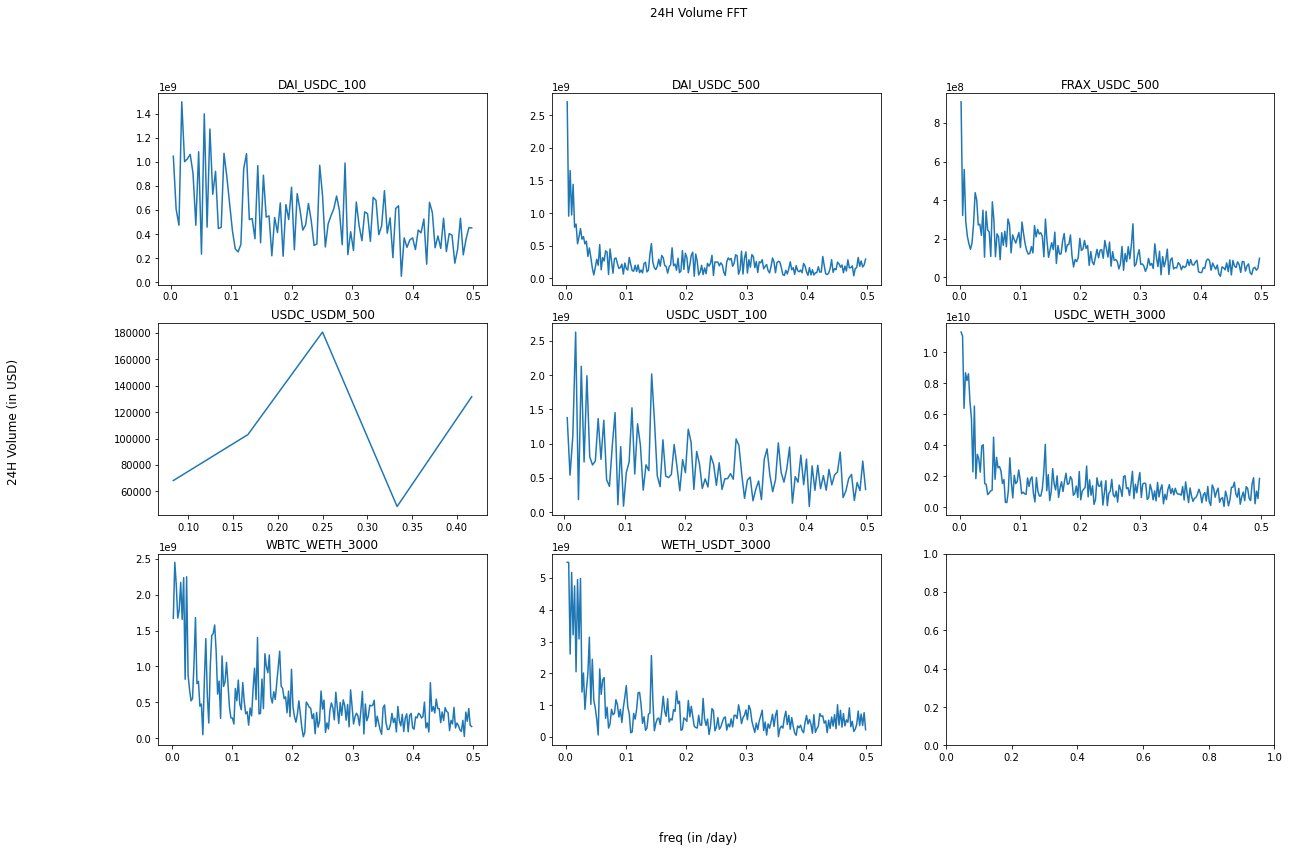

In [24]:
fig = plt.figure(figsize=(20, 12))
axes = fig.subplots(3, 3)
for i, pool_name in enumerate(pool_names):
    date_volume_df = df[["date", pool_name + "_volumeUSD"]].dropna()
    volumeUSD_series = date_volume_df[pool_name + "_volumeUSD"]

    # reference for zero-mean signal:
    # https://dsp.stackexchange.com/questions/46950/removing-mean-from-signal-massively-distorts-fft
    # only keep those with freq STRICTLY > 0
    f_max = math.ceil(date_volume_df.shape[0]/2)
    Y = abs(np.fft.fft(volumeUSD_series - volumeUSD_series.mean()))[1:f_max]
    freq = np.fft.fftfreq(date_volume_df.shape[0], 1)[1:f_max]

    ax = axes[math.floor(i/3), i%3]
    ax.title.set_text(pool_name)
    ax.plot(freq, Y)

fig.suptitle("24H Volume FFT")
fig.supxlabel("freq (in /day)")
fig.supylabel("24H Volume (in USD)")
plt.show()

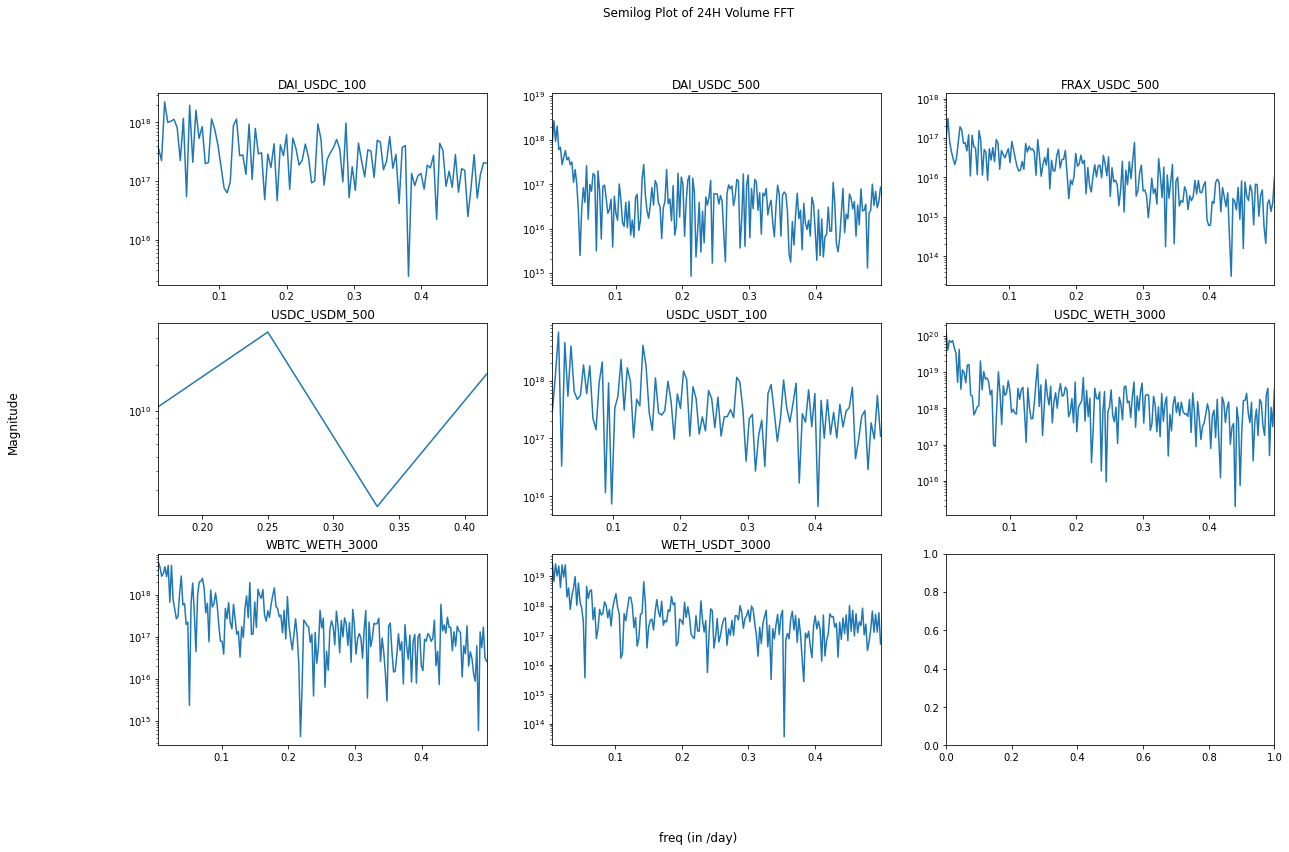

In [25]:
fig = plt.figure(figsize=(20, 12))
axes = fig.subplots(3, 3)
for i, pool_name in enumerate(pool_names):
    date_volume_df = df[["date", pool_name + "_volumeUSD"]].dropna()
    volumeUSD_series = date_volume_df[pool_name + "_volumeUSD"]

    # reference for zero-mean signal:
    # https://dsp.stackexchange.com/questions/46950/removing-mean-from-signal-massively-distorts-fft
    # only keep those with freq STRICTLY > 0
    f_max = math.ceil(date_volume_df.shape[0]/2)
    Y = abs(np.fft.fft(volumeUSD_series - volumeUSD_series.mean()))[1:f_max]
    freq = np.fft.fftfreq(date_volume_df.shape[0], 1)[1:f_max]

    # c.f. power spectral density in signal processing
    spectrum = Y.real*Y.real + Y.imag*Y.imag

    ax = axes[math.floor(i/3), i%3]
    ax.title.set_text(pool_name)
    ax.set_xlim(left=freq[1], right=freq[-1])

    # Note: this is possible because FFT must give positive values,
    # so that their logarithms always exist.
    # plot log10(spectrum) against frequency
    ax.semilogy(freq, spectrum)

fig.suptitle("Semilog Plot of 24H Volume FFT")
fig.supxlabel("freq (in /day)")
fig.supylabel("Magnitude")
plt.show()

## TVL Analysis

c:\Users\user\AppData\Local\pypoetry\Cache\virtualenvs\eth-uniswap-prelim-analysis-3WCyaTCY-py3.8\lib\site-packages\pwlf\pwlf.py:1234: RuntimeWarning: divide by zero encountered in double_scalars
  variance = np.dot(e, e) / (ny - nb)
c:\Users\user\AppData\Local\pypoetry\Cache\virtualenvs\eth-uniswap-prelim-analysis-3WCyaTCY-py3.8\lib\site-packages\pwlf\pwlf.py:1238: RuntimeWarning: invalid value encountered in multiply
  self.se = np.sqrt(variance * A2inv)


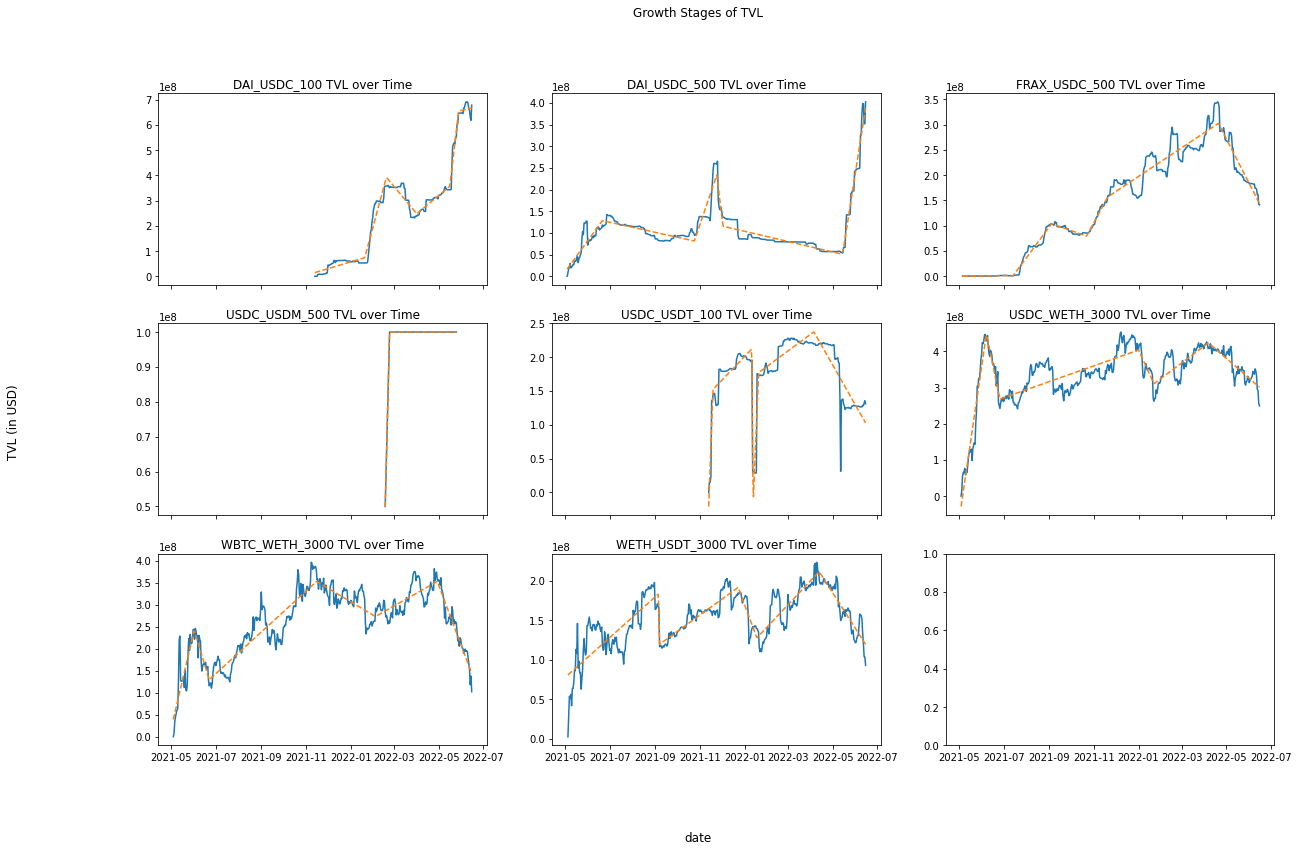

In [26]:
fig = plt.figure(figsize=(20, 12))
axes = fig.subplots(3, 3, sharex=True)
for i, pool_name in enumerate(pool_names):
    date_tvl_df = df[["date", pool_name + "_tvlUSD", "timestamp"]].dropna()
    # TODO: customize number of turning points
    reg_result = pwlf_helper.regression(date_tvl_df["timestamp"], date_tvl_df[pool_name + "_tvlUSD"], 6)

    ax = axes[math.floor(i/3), i%3]
    ax.title.set_text(pool_name + " TVL over Time")

    ax.plot(date_tvl_df["date"], date_tvl_df[pool_name + "_tvlUSD"])
    ax.plot(date_tvl_df["date"], reg_result.yHat, '--')

    # ax.legend(["TVL", "PWLF fitted trend line"])

    # # x-axis ticks are spaced out biweekly (for now)
    # ax.xticks(pd.date_range(date_tvl_df["date"].iloc[0], date_tvl_df["date"].iloc[-1], freq="14D"))

    # # annotate turning points
    # for tp in reg_result.tp[1:-1]:
    #     tp_date = dt.date.fromtimestamp(tp)
    #     tp_str = tp_date.strftime("%Y-%m-%d")
    #     pred = reg_result.predict(tp)
    #     ax.annotate(tp_str, xy=(tp_date, pred), xytext=(tp_date, pred+0.5e8),
    #         arrowprops=dict(arrowstyle="->", color='red')
    # )

fig.suptitle("Growth Stages of TVL")
fig.supxlabel("date")
fig.supylabel("TVL (in USD)")
plt.show()